In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *

In [4]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X = X.values.astype(float)
y = np.array(y).reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
bart = MultiBART(ndpost=2000, nskip=0, n_trees=100, proposal_probs=proposal_probs, multi_tries=10)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 2000/2000 [06:04<00:00,  5.48it/s]


In [6]:
from bart_playground.util import fast_choice_with_weights, fast_choice
generator = np.random.default_rng(42)

In [7]:
preprocessor = DefaultPreprocessor(max_bins=100)
data = preprocessor.fit_transform(X_train, y_train)
data_y = data.y
possible_thresholds = preprocessor._thresholds

In [8]:
tree = bart.trace[-1].trees[0]  # Select the first tree for demonstration
residuals = data_y - bart.trace[-1].evaluate(all_except=[0])
eps_sigma2 = bart.trace[-1].global_params["eps_sigma2"][0]
n_samples = 10

candidates = []
for _ in range(n_samples):
    node_id = fast_choice(generator, tree.leaves)
    var = fast_choice(generator, np.arange(tree.dataX.shape[1]))
    threshold = fast_choice(generator, possible_thresholds[var])
    
    # Use the combined simulation function instead of copy + split_leaf
    new_leaf_ids, new_n, new_vars = tree.simulate_split_leaf(node_id, var, threshold)

    # Check if split is valid (both children have samples)
    left_child = node_id * 2 + 1
    right_child = node_id * 2 + 2
    if new_n[left_child] > 0 and new_n[right_child] > 0:
        # Calculate likelihood using simulated data
        log_likelihood = bart.sampler.likelihood.calculate_simulated_likelihood(
            new_leaf_ids, new_n, residuals, eps_sigma2=eps_sigma2
        )
        
        # Calculate prior using simulated data
        log_prior = bart.sampler.tree_prior.calculate_simulated_prior(new_vars)
        
        log_pi = log_likelihood + log_prior
        candidates.append((node_id, var, threshold, 0.5*float(log_pi)))
    else:
        # Invalid split - set weight to 0 (log weight to -inf)
        candidates.append((node_id, var, threshold, -np.inf))

log_bwd_weights = np.array([w for _, _, _, w in candidates])

max_log_bwd = np.max(log_bwd_weights)
bwd_weights = np.exp(log_bwd_weights - max_log_bwd)
idx = fast_choice_with_weights(generator, np.arange(len(candidates)), bwd_weights) # Select y

In [9]:
# print all candidates
for i, (node_id, var, threshold, log_w) in enumerate(candidates):
    print(f"Candidate {i}: Node {node_id}, Var {var}, Threshold {threshold}, Log Weight {log_w:.4f}")

Candidate 0: Node 2, Var 6, Threshold 37.32, Log Weight -3888.8120
Candidate 1: Node 21, Var 3, Threshold 1.1383014908090896, Log Weight -3890.1788
Candidate 2: Node 2, Var 5, Threshold 2.338826976944624, Log Weight -3889.6748
Candidate 3: Node 2, Var 4, Threshold 3940.629999999999, Log Weight -3888.6923
Candidate 4: Node 39, Var 6, Threshold 37.62, Log Weight -inf
Candidate 5: Node 81, Var 4, Threshold 562.0, Log Weight -3892.2876
Candidate 6: Node 81, Var 3, Threshold 1.0493463773069036, Log Weight -3891.3119
Candidate 7: Node 20, Var 1, Threshold 47.0, Log Weight -inf
Candidate 8: Node 81, Var 5, Threshold 2.6666666666666665, Log Weight -inf
Candidate 9: Node 81, Var 4, Threshold 1071.0, Log Weight -3890.2959


<BarContainer object of 10 artists>

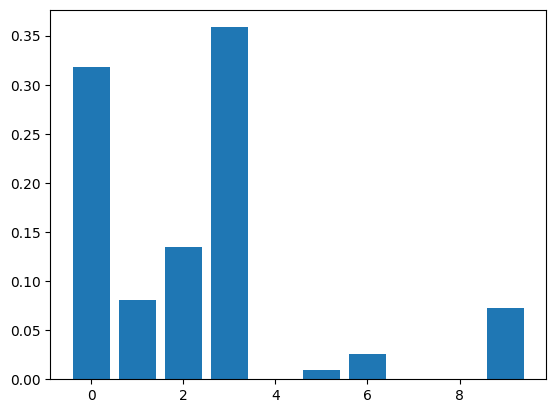

In [10]:
from matplotlib import pyplot as plt
plt.bar(np.arange(len(bwd_weights)), bwd_weights/bwd_weights.sum())

In [11]:
idx

np.int64(0)